# Machine Learning Capstone Project
## OpenAI Gym Pendulum

My first approach is to use an actor-critic method with deep deterministic gradient policy algorithm using the torch framework.

In [22]:
# reload on filechange
%load_ext autoreload
%autoreload 2

import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
from ddpg import DDPG
from types import SimpleNamespace

env = gym.make("Pendulum-v0")

# the pendulum has random initiations in each episode. To enable reproducibility we add a seed #
random_seed = 1
env.seed(random_seed)

# I train my model on a GPU but if not available this will resort to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# # Define the Agent

# hyperparams = {
#     "buffer_size"  : int(1e5),  # replay buffer size
#     "batch_size"   : 128,       # minibatch size
#     "gamma"        : 0.99,      # discount factor
#     "tau"          : 1e-3,      # for soft update of target parameters
#     "alpha_actor"  : 1e-4,      # learning rate of the actor
#     "alpha_critic" : 1e-3,      # learning rate of the critic
#     "weight_decay" : 0         # L2 weight decay
# }

# hyperparams = SimpleNamespace(**hyperparams)

# # state -> [cos(theta), sin(theta), theta_dt]
# # action -> [torque]
# # note: action space is also an array eventhough it has only one member

# agent = DDPG(state_size=3, action_size=1, random_seed=random_seed, hyperparams=hyperparams)

## Training the Model

My strategy is to calculate the score for each step, sum those scores to get the total episode score and collect those total scores to have an array of scores for all episodes. This way I can evaluate the agent's progress.
At every timestep the agent will take an action, get the observation(state) from the environment, choose the next action based on that state and calculate the score. 
Finally I will be saving the weights so I can render run the model without having to train the agent every time.

In [37]:
def train(num_episodes=500, time=200):
    scores = []
    avg_scores = []
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        agent.reset()
        score = 0
        for t in range(time):
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores.append(score)
        torch.save(agent.actor.state_dict(), "weights_actor.pth")
        torch.save(agent.critic.state_dict(), "weights_critic.pth")
        if (i_episode % 100 == 0):
            avg_100_score = np.mean(scores[i_episode-100: i_episode])
            print("Episode: ", i_episode, " Avg Reward: ", avg_100_score)
            avg_scores.append(avg_100_score)
    return scores, avg_scores

## Improvement and Visualization
Last but not least, we can see the progress the agent made by looking at the scores through time and then render the train model (by loading the weights below) and observe the pendulum's behaviour.

In [38]:
def plot_rewards(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

c:\users\arash\appdata\local\programs\python\python36\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode:  50  Avg Reward:  -513.9239397349577
Episode:  100  Avg Reward:  -291.2495966157938
Episode:  150  Avg Reward:  -265.94430512653884
Episode:  200  Avg Reward:  -241.252975175789
Episode:  250  Avg Reward:  -254.9430149358779
Episode:  300  Avg Reward:  -240.4790478633344
Episode:  350  Avg Reward:  -259.5950056864295
Episode:  400  Avg Reward:  -279.68968172367136
Episode:  450  Avg Reward:  -239.735156316325
Episode:  500  Avg Reward:  -242.11518515267727
Combination 1 
 Average Scores:  [-513.9239397349577, -291.2495966157938, -265.94430512653884, -241.252975175789, -254.9430149358779, -240.4790478633344, -259.5950056864295, -279.68968172367136, -239.735156316325, -242.11518515267727] 
 Params:  namespace(alpha_actor=0.0001, alpha_critic=0.001, batch_size=1024, buffer_size=100000, gamma=0.99, mu=0.0, sigma=0.01, tau=0.01, theta=0.15, weight_decay=0.99)


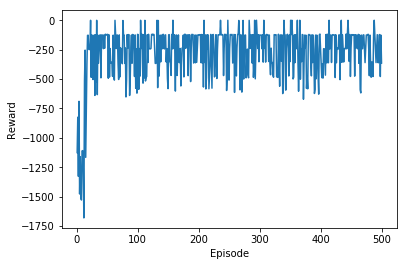

In [35]:
from sklearn.model_selection import ParameterGrid
hyperparam_grid = {
    "buffer_size"  : [int(1e5)],        # replay buffer size
    "batch_size"   : [1024],            # minibatch size
    "gamma"        : [0.99],            # discount factor
    "tau"          : [1e-2],            # tau, (1 - tau) for update ratio
    "alpha_actor"  : [1e-4],            # learning rate of the actor
    "alpha_critic" : [1e-3],            # learning rate of the critic
    "weight_decay" : [0.99],            # L2 weight decay
    "mu"           : [0.0],
    "theta"        : [0.15],
    "sigma"        : [0.01]
}

grid = ParameterGrid(hyperparam_grid)
top_scores = []
i = 1

for params in grid:
    params = SimpleNamespace(**params)
    agent = DDPG(state_size=3, action_size=1, random_seed=random_seed, hyperparams=params)
    scores, avg_scores = train()
    print('Combination', i,'\n','Average Scores: ', avg_scores, '\n','Params: ', params)
    if len(avg_scores)>0:
        top_scores.append(avg_scores[-1])
    plot_rewards(scores)
    i+=1

The plot below shows the contiuous average of the last 100 scores at each episode. This illustrates the improvement of the model better at it clearly shows the learning period and then when the agent's learning plateaus

c:\users\arash\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\arash\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


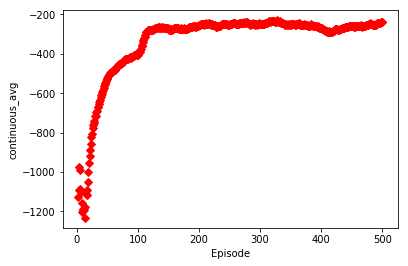

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
continuous_avg = []
for i in range(len(scores)):
    if(i<100):
        continuous_avg.append(np.mean((scores[0:i])))
    else:
        continuous_avg.append(np.mean(scores[i-100:i]))
plt.plot(np.arange(1, len(continuous_avg)+1), continuous_avg, 'rD')
plt.xlabel('Episode')
plt.ylabel('continuous_avg')
plt.show()

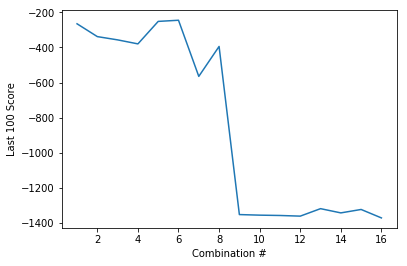

In [9]:
# DO NOT RUN this cell unless you want to compare new results - CURRENT OUTPUT WILL BE LOST!
# This cell was last ran after a 16 combination was run above. To try illustrate new combinations results re-run.
# The current scores are not the corresponsing scores for the graph below
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(top_scores)+1), top_scores)
plt.xlabel('Combination #')
plt.ylabel('Last 100 Score')
plt.show()

In [33]:
# DO NOT RUN this cell unless you want to compare new results - CURRENT OUTPUT WILL BE LOST!

from IPython.display import HTML, display
import tabulate

headers = []
i = 0
for params in grid:
    combination=[]
    for key, val in params.items():
        if i==0:
            headers.append(key)
        combination.append(val)
    if i==0:
        headers.insert(0, 'combination')
        table = [headers]
    i += 1
    combination.insert(0, i)
    table.append(combination)
    

    display(HTML(tabulate.tabulate(table, tablefmt='html')))

combination,alpha_actor,alpha_critic,batch_size,buffer_size,gamma,mu,sigma,tau,theta,weight_decay
1,0.0001,0.001,1024,100000,0.99,0.0,0.01,0.01,0.15,0
2,0.0001,0.001,1024,100000,0.99,0.0,0.01,0.001,0.15,0
3,0.0001,0.001,1024,100000,0.9,0.0,0.01,0.01,0.15,0
4,0.0001,0.001,1024,100000,0.9,0.0,0.01,0.001,0.15,0
5,0.0001,0.01,1024,100000,0.99,0.0,0.01,0.01,0.15,0
6,0.0001,0.01,1024,100000,0.99,0.0,0.01,0.001,0.15,0
7,0.0001,0.01,1024,100000,0.9,0.0,0.01,0.01,0.15,0
8,0.0001,0.01,1024,100000,0.9,0.0,0.01,0.001,0.15,0
9,0.01,0.001,1024,100000,0.99,0.0,0.01,0.01,0.15,0
10,0.01,0.001,1024,100000,0.99,0.0,0.01,0.001,0.15,0


### Let's see the agent in action

In [8]:
# To see the agent in action run this cell
# This cell uses the last trained weights saved

agent.actor.load_state_dict(torch.load('weights_actor.pth'))
agent.critic.load_state_dict(torch.load('weights_critic.pth'))

state = env.reset()
for i in range(3):
    env.reset()
    for t in range(200):
        action = agent.select_action(state, train=False)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            continue
env.close()

c:\users\arash\appdata\local\programs\python\python36\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
